In [0]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt

from tqdm import tqdm

In [0]:
!wget https://www.dropbox.com/s/4fo1lq10ulqyqy9/crossref_data.csv

--2020-05-22 18:21:41--  https://www.dropbox.com/s/4fo1lq10ulqyqy9/crossref_data.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4fo1lq10ulqyqy9/crossref_data.csv [following]
--2020-05-22 18:21:42--  https://www.dropbox.com/s/raw/4fo1lq10ulqyqy9/crossref_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8b08c0464f0bcf370c95bbb4f7.dl.dropboxusercontent.com/cd/0/inline/A4NIV13JTKNUQblp34UscxTw3grZ3ZgxwKJFLx2WW1yr87Kvlb6q4UCiP2AwvAGhZmmmGyM5RdRfZpBAkHtszImdXiJRAhVfNcn2Ao9zUYIWb4Su-LUcL5z3t4blAeSeWw4/file# [following]
--2020-05-22 18:21:42--  https://uc8b08c0464f0bcf370c95bbb4f7.dl.dropboxusercontent.com/cd/0/inline/A4NIV13JTKNUQblp34UscxTw3grZ3ZgxwKJFLx2WW1yr87Kvlb6q4UCiP2AwvAGhZmmmGyM5RdRfZpBAkHtszImdXiJRAhVfNcn

In [0]:
# df = pd.read_parquet('crossref_data.parquet')

In [0]:
# CHUNCK TEST

chunksize = 100_000

df = pd.DataFrame()
chunk_stream = pd.read_csv('crossref_data.csv', chunksize=chunksize, low_memory=False)

c = 0
for chunk in tqdm(chunk_stream):
    df = pd.concat([df, chunk])
    c += 1
    if c >= 10:
      break

df.head()

In [0]:
sum(df['subject'].notna())

465136

In [0]:
import ast
import csv

from itertools import chain
from collections import Counter


chunksize = 500_000
total = 0
notna_subj = 0

In [0]:
# COMMENTED: WRITING ONLY SUBJ-HAVING ROWS


subjects_counter = Counter()

chunk_stream = pd.read_csv('crossref_data.csv', chunksize=chunksize, low_memory=False)

#with open('has_subject.csv', 'w', encoding='utf-8') as f:
#  csvwriter = csv.writer(f)
#  csvwriter.writerow(['DOI', 'title', 'abstract', 'subject'])
    
for i, chunk in enumerate(chunk_stream):
  chunk = chunk.drop_duplicates(subset=['DOI'])
  total += chunk.shape[0]
  notna_subj += sum(chunk['subject'].notna())
  curr_subjs = [subj for subj in chunk['subject']]
  curr_subjs = [ast.literal_eval(x) for x in curr_subjs if isinstance(x, str)]
  subjects_counter += Counter(chain(*curr_subjs))
    
  #subchunk = chunk[chunk['subject'].notna()]
  #subchunk.to_csv(path_or_buf='has_subject.csv', mode='a')

  print(f"Chunk {i}")

print(f"{i} chunks in total")

Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
13 chunks in total


In [0]:
# PARQUET WRITING

#csv_file = 'crossref_data.csv'
#parquet_file = 'crossref_data.parquet'
csv_file = 'has_subject.csv'
parquet_file = 'has_subject.parquet'
chunksize = 100_000

csv_stream = pd.read_csv(csv_file, chunksize=chunksize, low_memory=False)

for i, chunk in tqdm(enumerate(csv_stream)):
    if i == 0:
        # Guess the schema of the CSV file from the first chunk
        parquet_schema = pa.Table.from_pandas(df=chunk).schema
        # Open a Parquet file for writing
        parquet_writer = pq.ParquetWriter(parquet_file, parquet_schema, compression='snappy')
    # Write CSV chunk to the parquet file
    table = pa.Table.from_pandas(chunk, schema=parquet_schema)
    parquet_writer.write_table(table)

parquet_writer.close()




0it [00:02, ?it/s]


KeyError: ignored

In [0]:
total, notna_subj, notna_subj / total

(6984273, 2348224, 0.33621595261239073)

In [0]:
len(subjects_counter)

319

In [0]:
subjects_counter.most_common(20)

[('General Medicine', 214471),
 ('Immunology', 207135),
 ('Cell Biology', 199122),
 ('Biochemistry', 180095),
 ('Hematology', 137032),
 ('Mechanical Engineering', 133543),
 ('Condensed Matter Physics', 129709),
 ('General Materials Science', 125180),
 ('General Chemistry', 107291),
 ('Mechanics of Materials', 105323),
 ('Molecular Biology', 101864),
 ('Physiology', 97734),
 ('Animal Science and Zoology', 97703),
 ('Ecology, Evolution, Behavior and Systematics', 88994),
 ('Microbiology', 72324),
 ('Oncology', 63943),
 ('History', 61235),
 ('Agronomy and Crop Science', 59507),
 ('Plant Science', 59178),
 ('Cancer Research', 55922)]

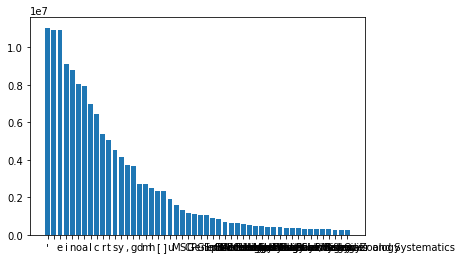

In [0]:
sorted_counter = dict(subjects_counter.most_common(50))

plt.bar(sorted_counter.keys(), sorted_counter.values())
#plt.yscale('log')
plt.show()

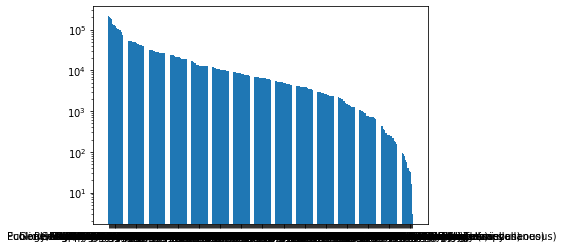

In [0]:
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.yscale('log')
plt.show()

In [0]:
len([k for k, v in sorted_counter.items() if v >= 50_000]), len([k for k, v in sorted_counter.items() if v >= 10_000]), len(sorted_counter)

(28, 123, 319)

In [0]:
# LIST OF ALL SUBJECTS

print('\n'.join(sorted(subjects_counter.keys(),
                       key=lambda x: x[0])))

In [0]:
chunksize = 100_000
total = 0
notna_subj = 0

chunk_stream = pd.read_csv('has_subject.csv', chunksize=chunksize, low_memory=False)

#with open('has_subject.csv', 'w', encoding='utf-8') as f:
#  csvwriter = csv.writer(f)
#  csvwriter.writerow(['DOI', 'title', 'abstract', 'subject'])
    
for i, chunk in enumerate(chunk_stream):
  chunk = chunk.drop_duplicates(subset=['DOI'])
  total += chunk.shape[0]
  notna_subj += sum(chunk['subject'].notna())
  curr_subjs = [subj for subj in chunk['subject']]
  #curr_subjs = [ast.literal_eval(x) for x in curr_subjs if isinstance(x, str)]
  subjects_counter += Counter(chain(*curr_subjs))
    
  #subchunk = chunk[chunk['subject'].notna()]
  #subchunk.to_csv(path_or_buf='has_subject.csv', mode='a')

  print(f"Chunk {i}")

print(f"{i} chunks in total")

Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
Chunk 14
Chunk 15
Chunk 16
Chunk 17
Chunk 18
Chunk 19
Chunk 20
Chunk 21
Chunk 22
Chunk 23
23 chunks in total


In [0]:
total, notna_subj

(2345238, 2345238)

In [0]:
chunk.head()

,DOI,title,abstract,subject
6886129,10.1093/clinchem/27.9.1524,['Relationships between immunogen structure an...,<jats:title>Abstract</jats:title>\n ...,"['Clinical Biochemistry', 'Biochemistry, medic..."
6886130,10.1093/clinchem/41.9.1288,['Low plasma concentrations of retinol-binding...,<jats:title>Abstract</jats:title>\n ...,"['Clinical Biochemistry', 'Biochemistry, medic..."
6886131,10.1093/clinchem/46.4.543,['Clinical Outcomes of Point-of-Care Testing i...,<jats:title>Abstract</jats:title>\n ...,"['Clinical Biochemistry', 'Biochemistry, medic..."
6886133,10.1128/cdli.5.4.446-451.1998,['Detection of Mycobacterium avium subsp.parat...,<jats:title>ABSTRACT</jats:title>\n ...,"['Immunology', 'Immunology and Allergy', 'Micr..."
6886134,10.1128/jb.180.3.594-599.1998,['Identification of Campylobacter jejuniPromot...,<jats:title>ABSTRACT</jats:title>\n ...,"['Molecular Biology', 'Microbiology']"


In [0]:
list(chunk[:10].subject)

["['Clinical Biochemistry', 'Biochemistry, medical']",
 "['Clinical Biochemistry', 'Biochemistry, medical']",
 "['Clinical Biochemistry', 'Biochemistry, medical']",
 "['Immunology', 'Immunology and Allergy', 'Microbiology (medical)', 'Clinical Biochemistry']",
 "['Molecular Biology', 'Microbiology']",
 "['Molecular Biology', 'Microbiology']",
 "['Molecular Biology', 'Microbiology']",
 "['Immunology', 'Cell Biology', 'Biochemistry', 'Hematology']",
 "['Cancer Research', 'Oncology']",
 "['Clinical Biochemistry', 'Biochemistry, medical']"]

In [0]:
np.unique(chunk.subject).shape

(1278,)

In [0]:
chunk.shape

(45239, 4)